# Importing libraries and loading data

In [1]:
!pip install -q feature_engine

In [2]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings 
warnings.filterwarnings("ignore")

import shap
import matplotlib.pyplot as plt
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from feature_engine.encoding import RareLabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import re

pd.set_option('display.max_rows', 1000)

In [3]:
df = pd.read_csv('/kaggle/input/top-10000-spotify-songs-1960-now/top_10000_1960-now.csv').drop_duplicates()
print(df.shape)
df.sample(5).T

(9951, 35)


,7656,2535,8961,6240,2552
Track URI,spotify:track:1KZyVnyptQcPzkx7ELCnZC,spotify:track:48td6xvpokdYwvbl3JIiXP,spotify:track:7ngRS53kqxLcEt9Pythc5d,spotify:track:43UgnGOThTG3uSh4elH6xn,spotify:track:4L9J2or96xvWhQwWw09fHO
Track Name,Hold Back The River,Love Never Felt So Good,You Don't Own Me,Pumped Up,Mockingbird
Artist URI(s),spotify:artist:4EzkuveR9pLvDVFNx6foYD,"spotify:artist:3fMbdgg4jU18AjLCKBhRSm, spotify...",spotify:artist:08b2PA6eFyugsWAk41eQKZ,spotify:artist:1L9i6qZYIGQedgM9QLSyzb,spotify:artist:3aBkeBhwadnWMWoVJ2CxJC
Artist Name(s),James Bay,"Michael Jackson, Justin Timberlake",Lesley Gore,Klingande,Rob Thomas
Album URI,spotify:album:3GqsyMrJu3o8jLiGyBsBQW,spotify:album:7pomP86PUhoJpY3fsC0WDQ,spotify:album:5eluBwSJ7uwDBizWCiazSJ,spotify:album:64u2DVv5xzNTqTTkMza5GH,spotify:album:72aNaOna8AV0GZADXRbFlX
Album Name,Chaos And The Calm,XSCAPE,Lesley Gore Sings Of Mixed-Up Hearts,Pumped Up,Cradlesong
Album Artist URI(s),spotify:artist:4EzkuveR9pLvDVFNx6foYD,spotify:artist:3fMbdgg4jU18AjLCKBhRSm,spotify:artist:08b2PA6eFyugsWAk41eQKZ,spotify:artist:1L9i6qZYIGQedgM9QLSyzb,spotify:artist:3aBkeBhwadnWMWoVJ2CxJC
Album Artist Name(s),James Bay,Michael Jackson,Lesley Gore,Klingande,Rob Thomas
Album Release Date,2015-03-20,2014-05-09,1963-11-01,2017-09-08,2009-06-22
Album Image URL,https://i.scdn.co/image/ab67616d0000b273066483...,https://i.scdn.co/image/ab67616d0000b273ed8156...,https://i.scdn.co/image/ab67616d0000b2731f88f8...,https://i.scdn.co/image/ab67616d0000b2732ddf9c...,https://i.scdn.co/image/ab67616d0000b273da8f63...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9951 entries, 0 to 9998
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Track URI             9951 non-null   object 
 1   Track Name            9950 non-null   object 
 2   Artist URI(s)         9949 non-null   object 
 3   Artist Name(s)        9950 non-null   object 
 4   Album URI             9949 non-null   object 
 5   Album Name            9950 non-null   object 
 6   Album Artist URI(s)   9949 non-null   object 
 7   Album Artist Name(s)  9949 non-null   object 
 8   Album Release Date    9949 non-null   object 
 9   Album Image URL       9947 non-null   object 
 10  Disc Number           9951 non-null   int64  
 11  Track Number          9951 non-null   int64  
 12  Track Duration (ms)   9951 non-null   int64  
 13  Track Preview URL     7067 non-null   object 
 14  Explicit              9951 non-null   bool   
 15  Popularity           

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Disc Number,9951.0,1.035072,0.328352,0.000000,1.0000,1.000000,1.000000,15.000
Track Number,9951.0,4.956688,5.506272,0.000000,1.0000,3.000000,7.000000,93.000
Track Duration (ms),9951.0,224810.312129,54068.532640,0.000000,192646.5000,219920.000000,250194.000000,1561133.000
Popularity,9951.0,37.557934,29.430952,0.000000,0.0000,42.000000,64.000000,98.000
Danceability,9949.0,0.607831,0.145897,0.000000,0.5150,0.617000,0.710000,0.988
Energy,9949.0,0.683381,0.191167,0.000020,0.5600,0.712000,0.836000,0.997
Key,9949.0,5.169866,3.579402,0.000000,2.0000,5.000000,8.000000,11.000
Loudness,9949.0,-7.264895,3.283059,-29.368000,-9.0590,-6.515000,-4.881000,2.769
Mode,9949.0,0.698060,0.459122,0.000000,0.0000,1.000000,1.000000,1.000
Speechiness,9949.0,0.065147,0.061374,0.000000,0.0331,0.042900,0.067600,0.711


In [6]:
df.columns

Index(['Track URI', 'Track Name', 'Artist URI(s)', 'Artist Name(s)',
       'Album URI', 'Album Name', 'Album Artist URI(s)',
       'Album Artist Name(s)', 'Album Release Date', 'Album Image URL',
       'Disc Number', 'Track Number', 'Track Duration (ms)',
       'Track Preview URL', 'Explicit', 'Popularity', 'ISRC', 'Added By',
       'Added At', 'Artist Genres', 'Danceability', 'Energy', 'Key',
       'Loudness', 'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness',
       'Liveness', 'Valence', 'Tempo', 'Time Signature', 'Album Genres',
       'Label', 'Copyrights'],
      dtype='object')

In [7]:
df['Artist Name(s)'].value_counts().head(20)

Taylor Swift          48
P!nk                  45
Elvis Presley         42
Ed Sheeran            40
Madonna               39
U2                    38
The Beatles           38
The Rolling Stones    33
INXS                  30
Bee Gees              30
Katy Perry            30
Kylie Minogue         28
Elton John            28
Queen                 27
Britney Spears        27
Black Eyed Peas       27
Justin Bieber         27
Powderfinger          27
Maroon 5              27
Bon Jovi              26
Name: Artist Name(s), dtype: int64

# Data transformation

In [8]:
# select label
main_label = 'Popularity'
# exclude records with zero popularity
df = df[df[main_label]>0]
# extract song duration in minutes and group with larger bins
df['duration_minutes'] = df['Track Duration (ms)'].apply(lambda x: str(round(x/6e4)))
# extract song release year
df['release_year'] = df['Album Release Date'].fillna('None').apply(lambda x: x[:4])
# group columns to larger bins
for col in ['Acousticness', 'Danceability', 'Energy', 'Instrumentalness', 'Liveness', 'Speechiness', 'Valence']:
    df[col] = df[col].apply(lambda x: round(x,1))
df['Loudness'] = df['Loudness'].apply(lambda x: 5*round(1/5*x))
df['Tempo'] = df['Tempo'].apply(lambda x: 20*round(1/20*x))
# set up the rare label encoder limiting number of categories to max_n_categories
for col in ['Artist Name(s)', 'release_year', 'duration_minutes', 'Label']:
    df[col] = df[col].fillna('None')
    encoder = RareLabelEncoder(n_categories=1, max_n_categories=70, replace_with='Other', tol=12/df.shape[0])
    df[col] = encoder.fit_transform(df[[col]])
# drop unused columns
cols2drop = ['Track URI', 'Track Name', 'Artist URI(s)', 'Album URI', 'Album Name', 'ISRC', 'Track Number', 'Disc Number',
             'Album Artist URI(s)', 'Album Artist Name(s)', 'Album Image URL', 'Copyrights', 'Album Genres', 'Artist Genres',
             'Track Preview URL', 'Track Duration (ms)', 'Album Release Date', 'Label', 'Added By', 'Added At']
df = df.drop(cols2drop, axis=1)
print(df.shape)
df.sample(5).T

(7293, 17)


,5151,2954,8522,9024,3131
Artist Name(s),Other,Other,Other,Other,Other
Explicit,False,False,False,False,False
Popularity,73,74,46,48,50
Danceability,0.6,0.5,0.4,0.7,0.3
Energy,1.0,0.7,0.6,0.4,0.3
Key,8.0,1.0,4.0,2.0,11.0
Loudness,-5,-5,-5,-5,-10
Mode,1.0,0.0,0.0,0.0,0.0
Speechiness,0.1,0.1,0.1,0.1,0.0
Acousticness,0.0,0.2,0.0,0.4,0.9


# Machine learning

In [9]:
# initialize data
y = df[main_label].values.reshape(-1,)
X = df.drop([main_label], axis=1)
cat_cols = df.select_dtypes(include=['object']).columns
cat_cols_idx = [list(X.columns).index(c) for c in cat_cols]
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.5, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3646, 16), (3647, 16), (3646,), (3647,))

In [10]:
# initialize Pool
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=cat_cols_idx)
test_pool = Pool(X_test,
                 y_test,
                 cat_features=cat_cols_idx)
# specify the training parameters 
model = CatBoostRegressor(iterations=300,
                          depth=6, 
                          learning_rate=0.07,
                          verbose=0,
                          loss_function='RMSE')
#train the model
model.fit(train_pool)
# make the prediction using the resulting model
y_train_pred = model.predict(train_pool)
y_test_pred = model.predict(test_pool)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"RMSE score for train {round(rmse_train,2)} points, and for test {round(rmse_test,2)} points")

RMSE score for train 18.22 points, and for test 19.87 points


In [11]:
# Baseline scores (assuming the same prediction for all data samples)
rmse_bs_train = mean_squared_error(y_train, [np.mean(y_train)]*len(y_train), squared=False)
rmse_bs_test = mean_squared_error(y_test, [np.mean(y_train)]*len(y_test), squared=False)
print(f"RMSE baseline score for train {round(rmse_bs_train,2)} points, and for test {round(rmse_bs_test,2)} points")

RMSE baseline score for train 22.16 points, and for test 21.67 points


# Explanations with SHAP values

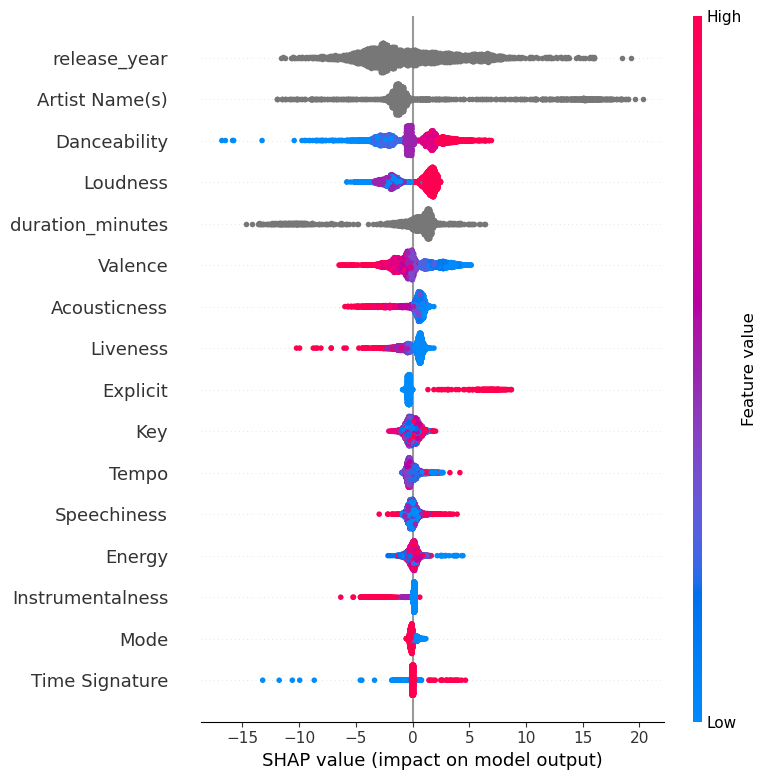

In [12]:
shap.initjs()
ex = shap.TreeExplainer(model)
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=30)

In [13]:
expected_values = ex.expected_value
print(f"Average predicted rating is {round(expected_values,2)} points")
print(f"Average actual rating is {round(np.mean(y_test),2)} points")

Average predicted rating is 51.13 points
Average actual rating is 51.36 points



Artist Name(s)



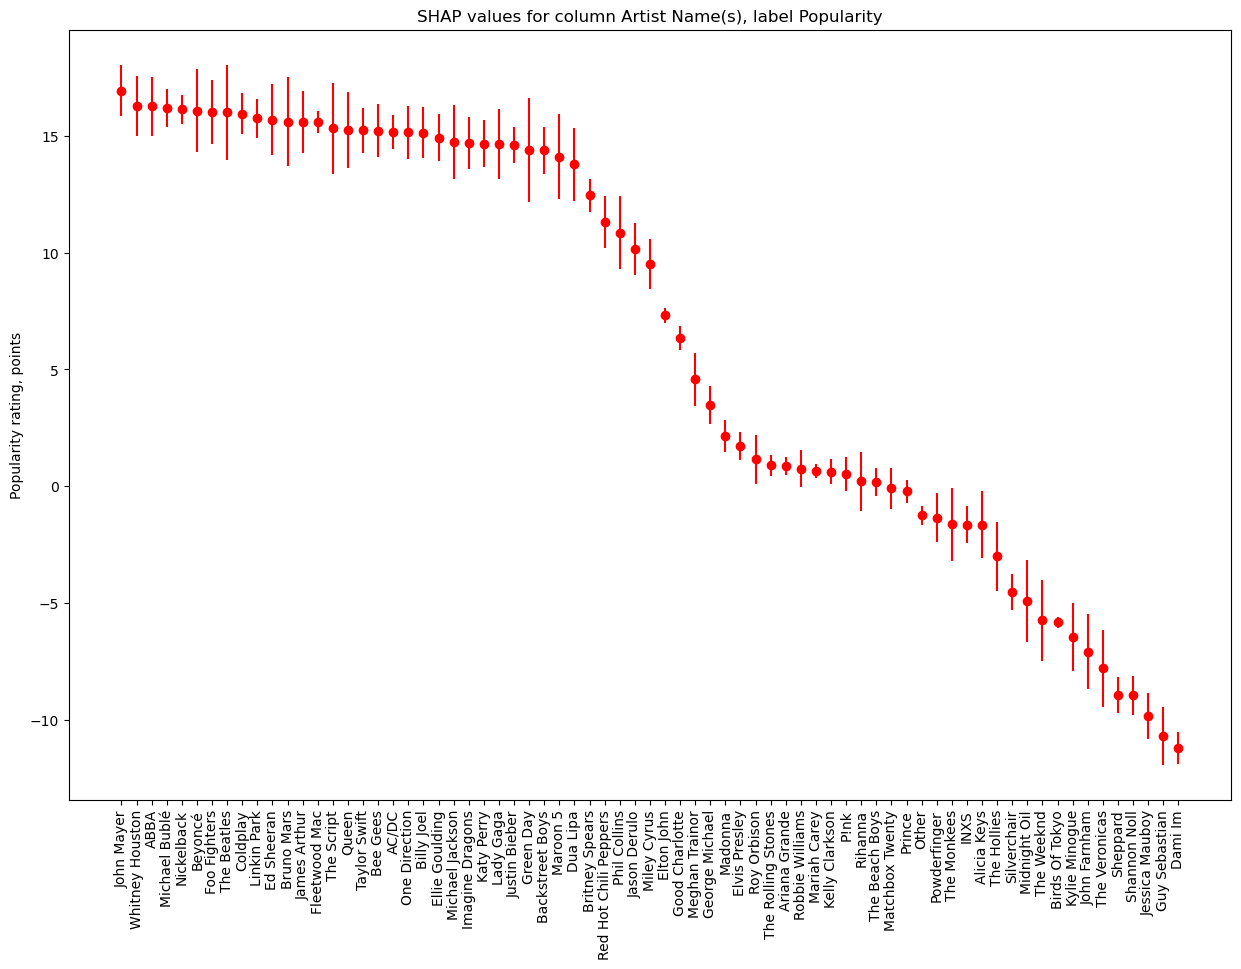

                          gain  gain_std  count
col                                            
John Mayer             16.9292    1.1074      8
Whitney Houston        16.2694    1.2853      8
ABBA                   16.2561    1.2650     11
Michael Bublé          16.1994    0.8187      8
Nickelback             16.1255    0.6178     10
Beyoncé                16.0760    1.7816      7
Foo Fighters           16.0115    1.3739     14
The Beatles            15.9938    2.0520     15
Coldplay               15.9401    0.8768      9
Linkin Park            15.7447    0.8285     11
Ed Sheeran             15.6801    1.5198     16
Bruno Mars             15.6007    1.9116      9
James Arthur           15.5900    1.3110      5
Fleetwood Mac          15.5833    0.4700      7
The Script             15.3170    1.9415     11
Queen                  15.2439    1.6360     10
Taylor Swift           15.2245    0.9746     14
Bee Gees               15.2029    1.1328     12
AC/DC                  15.1679    0.7369

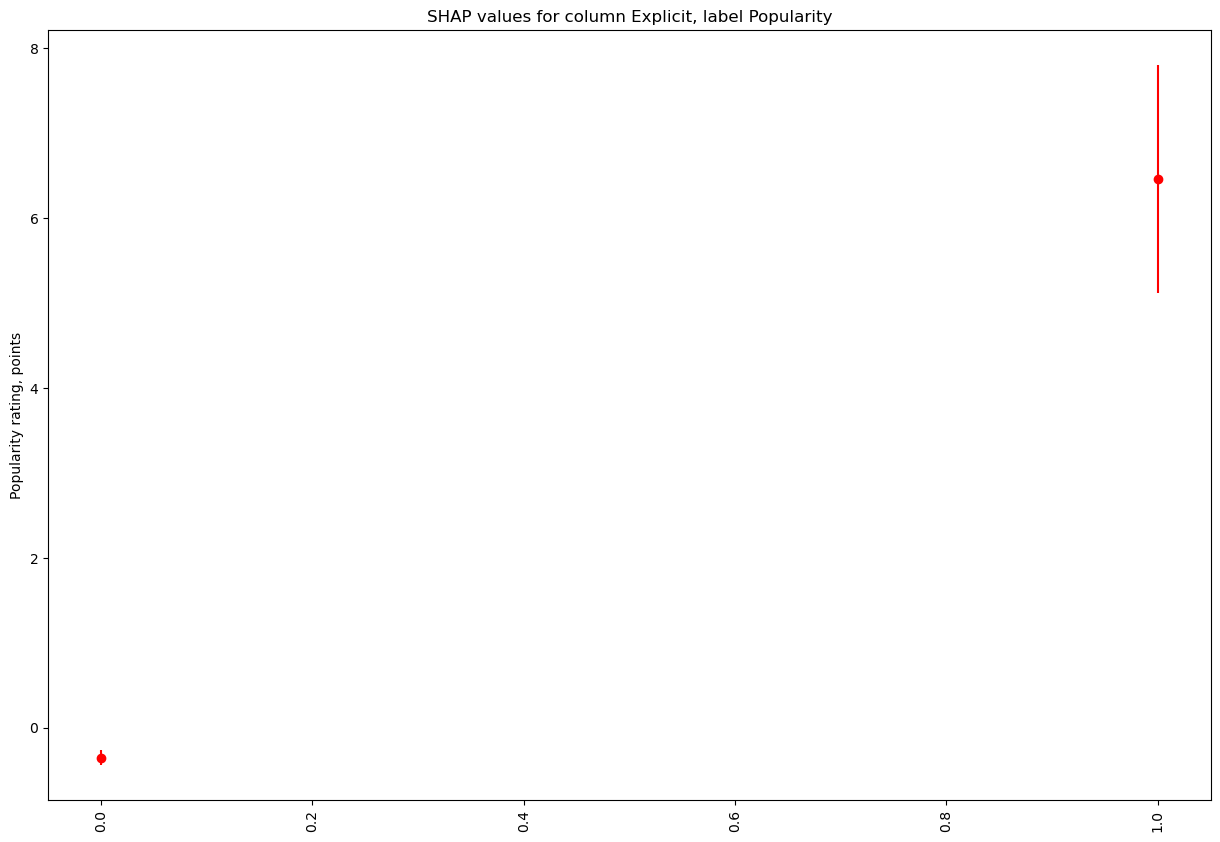

         gain  gain_std  count
col                           
True   6.4561    1.3432    188
False -0.3524    0.0872   3459

Danceability



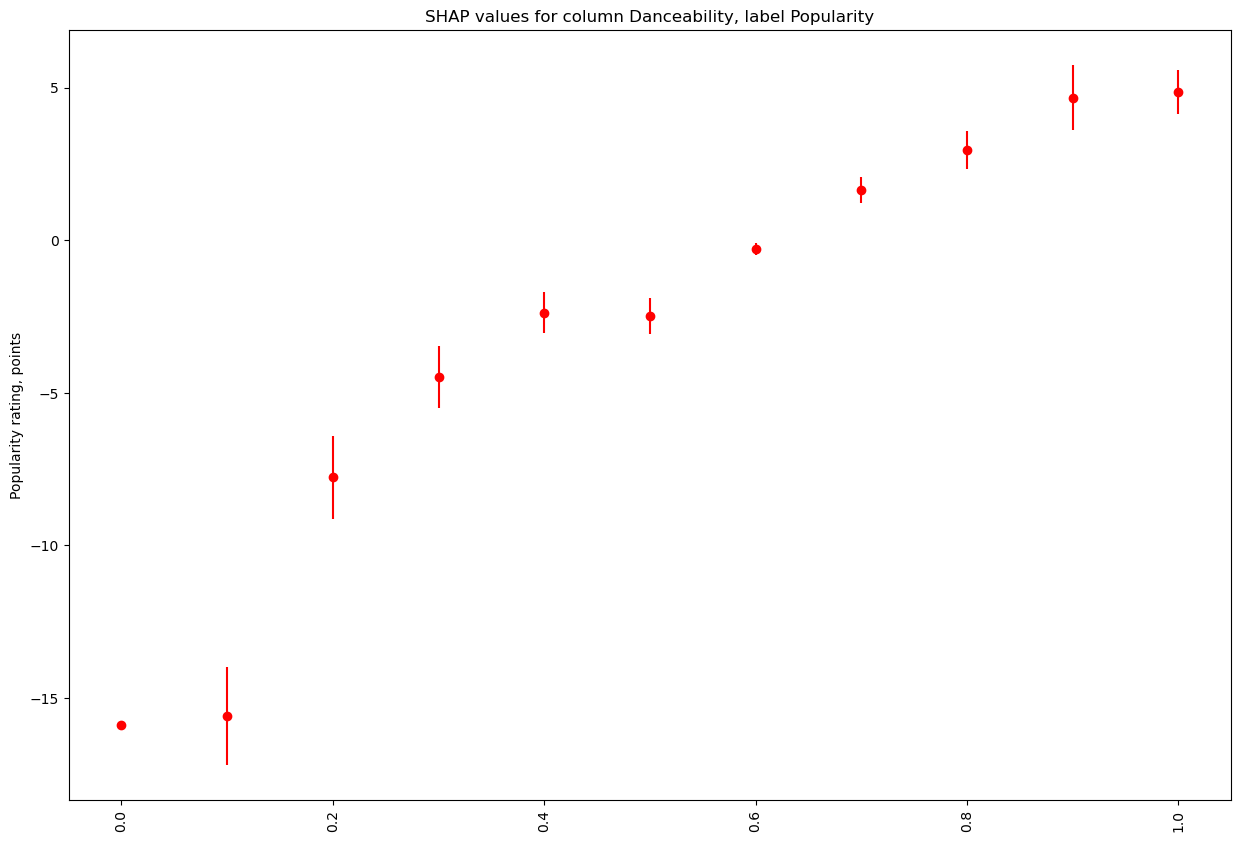

        gain  gain_std  count
col                          
1.0   4.8401    0.7182      8
0.9   4.6712    1.0619    124
0.8   2.9627    0.6207    440
0.7   1.6450    0.4130    921
0.6  -0.2866    0.1859    975
0.4  -2.3726    0.6790    357
0.5  -2.4788    0.5880    653
0.3  -4.4858    1.0169    132
0.2  -7.7600    1.3604     32
0.1 -15.5871    1.6078      4
0.0 -15.8681       NaN      1

Energy



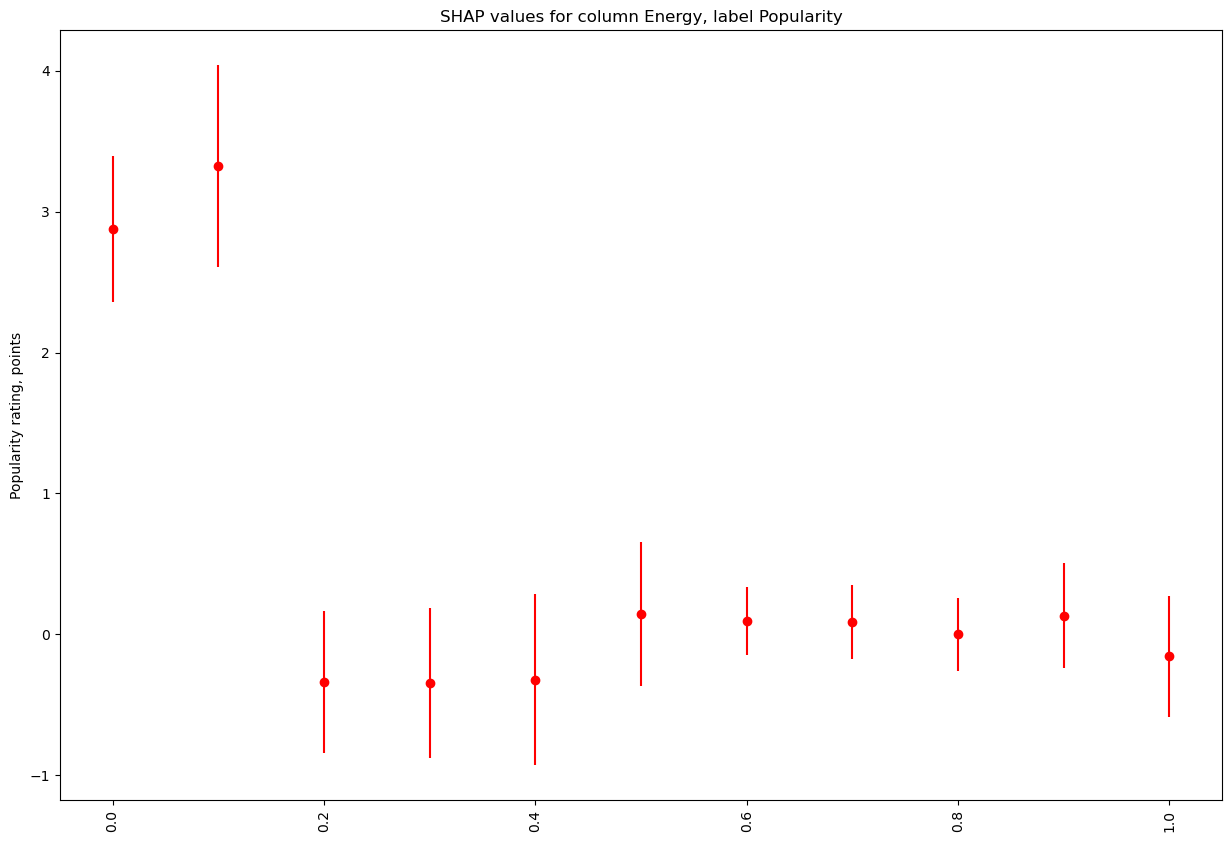

       gain  gain_std  count
col                         
0.1  3.3243    0.7152     16
0.0  2.8766    0.5159      4
0.5  0.1423    0.5097    386
0.9  0.1333    0.3708    680
0.6  0.0932    0.2393    509
0.7  0.0884    0.2624    688
0.8  0.0015    0.2593    765
1.0 -0.1570    0.4317    128
0.4 -0.3206    0.6077    259
0.2 -0.3363    0.5040     65
0.3 -0.3445    0.5325    147

Key



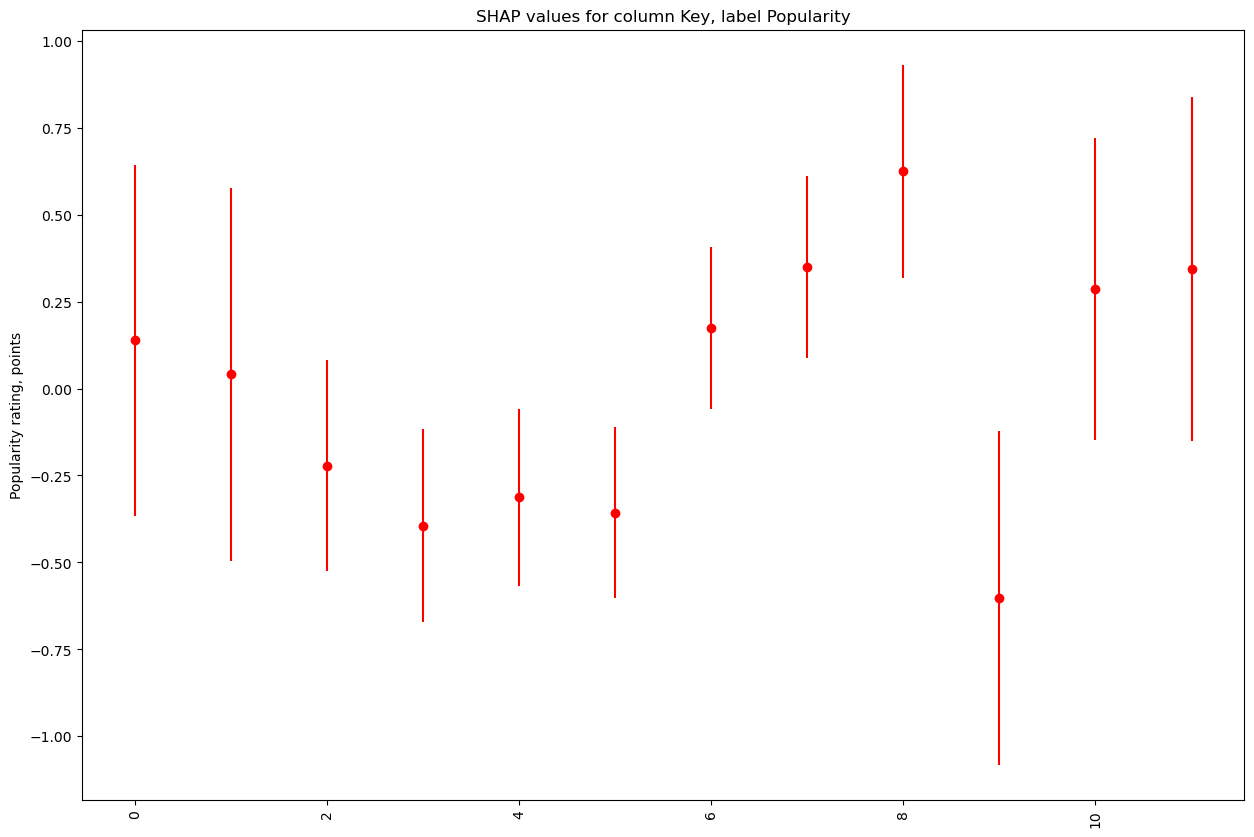

        gain  gain_std  count
col                          
8.0   0.6257    0.3063    230
7.0   0.3503    0.2623    396
11.0  0.3444    0.4956    250
10.0  0.2858    0.4352    211
6.0   0.1740    0.2332    252
0.0   0.1390    0.5054    489
1.0   0.0405    0.5365    305
2.0  -0.2223    0.3033    381
4.0  -0.3126    0.2550    287
5.0  -0.3570    0.2464    339
3.0  -0.3950    0.2779    114
9.0  -0.6018    0.4797    393

Loudness



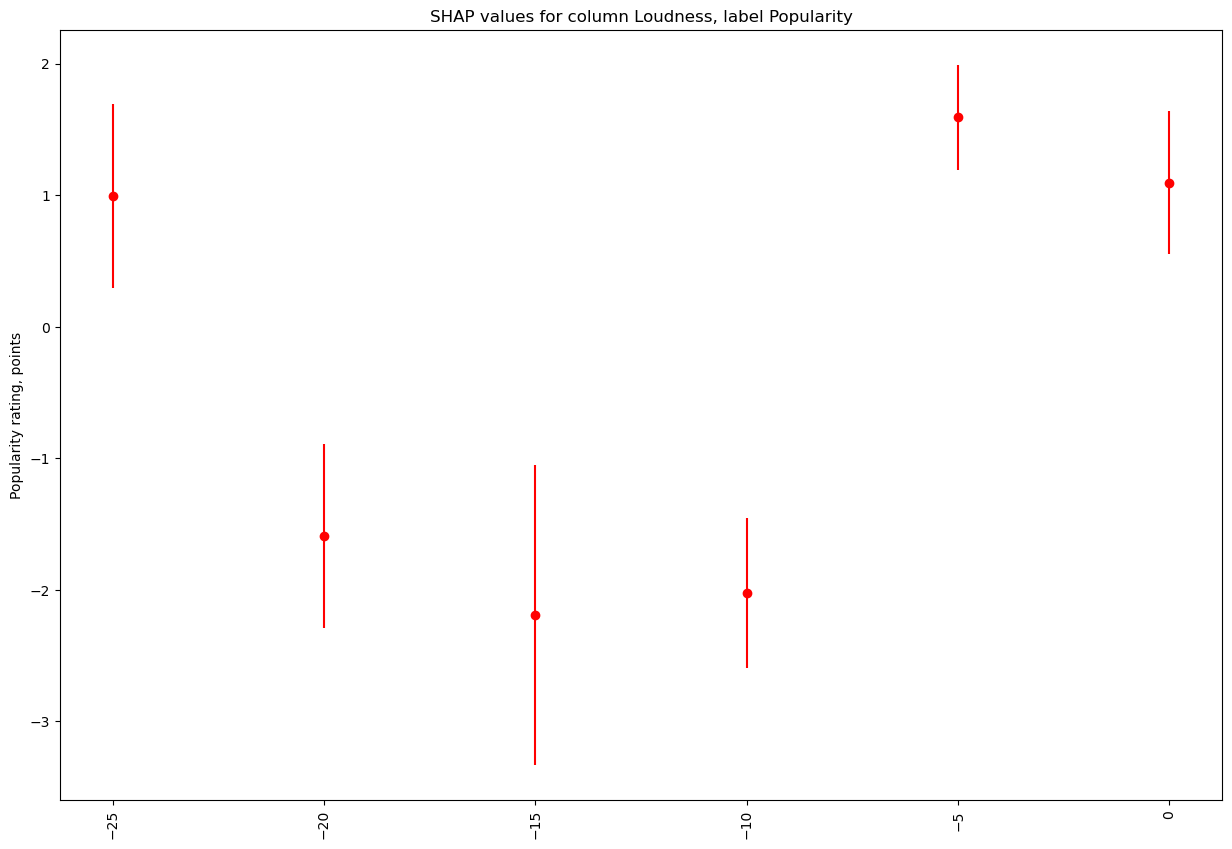

       gain  gain_std  count
col                         
-5   1.5900    0.3994   2218
 0   1.0926    0.5430     68
-25  0.9938    0.6984      3
-20 -1.5912    0.6962     15
-10 -2.0251    0.5701   1056
-15 -2.1904    1.1405    287

Mode



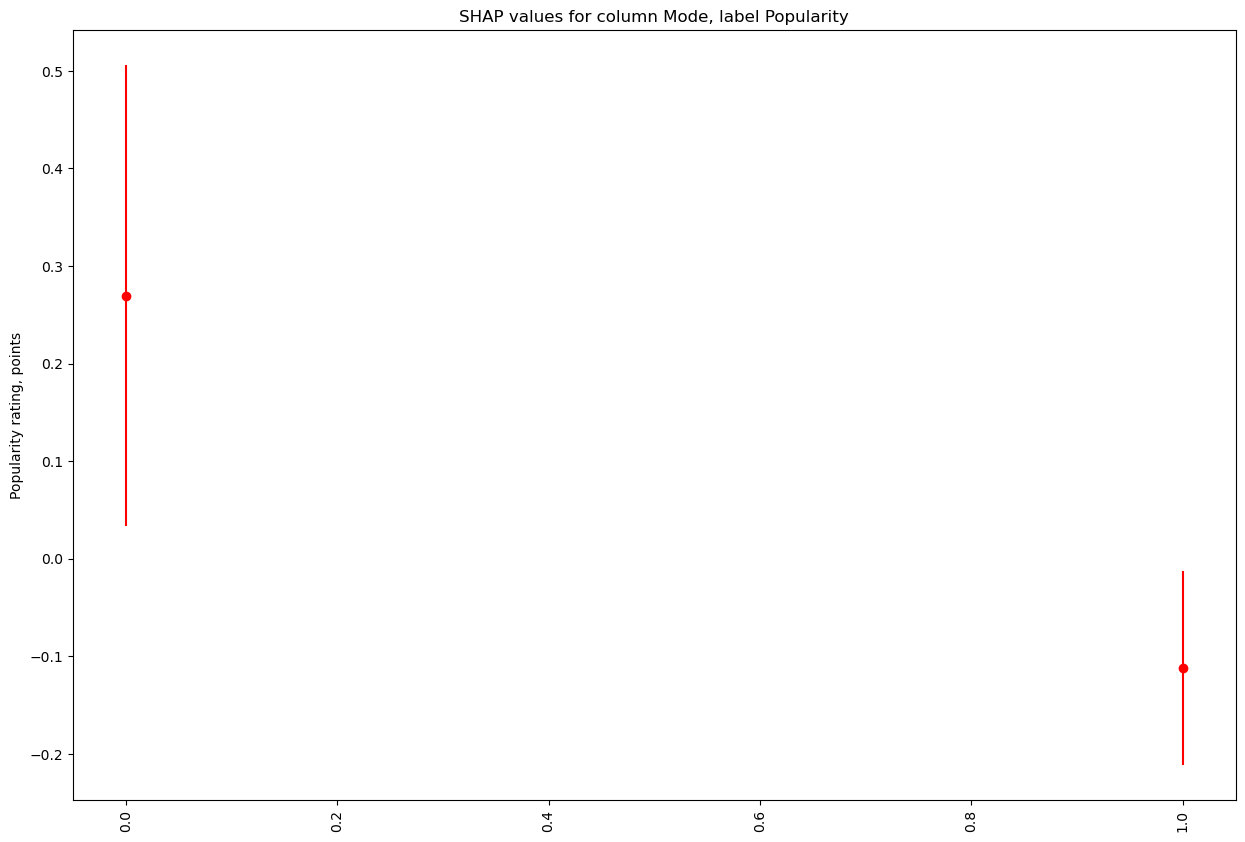

       gain  gain_std  count
col                         
0.0  0.2697    0.2362   1059
1.0 -0.1121    0.0994   2588

Speechiness



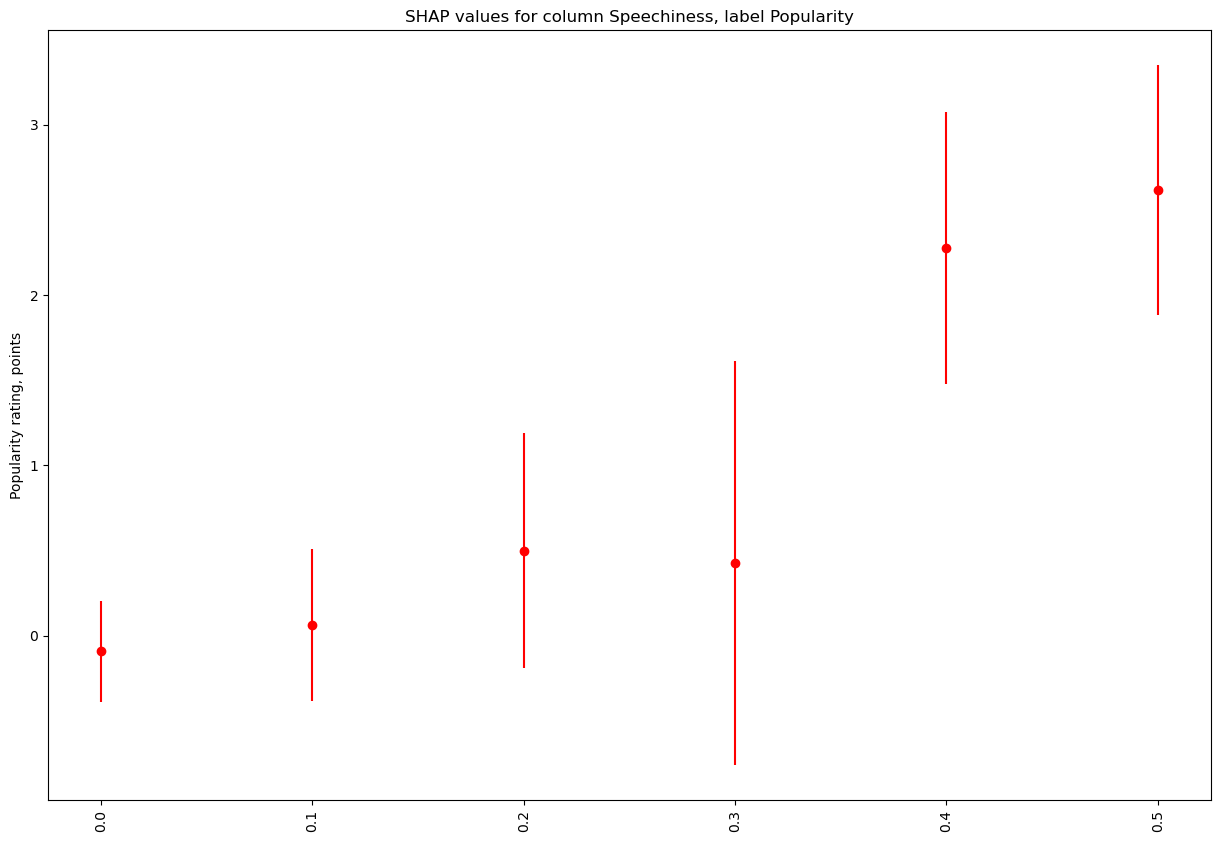

       gain  gain_std  count
col                         
0.5  2.6172    0.7325      8
0.4  2.2755    0.7974     14
0.2  0.4986    0.6892    148
0.3  0.4264    1.1867     87
0.1  0.0646    0.4455   1160
0.0 -0.0921    0.2960   2230

Acousticness



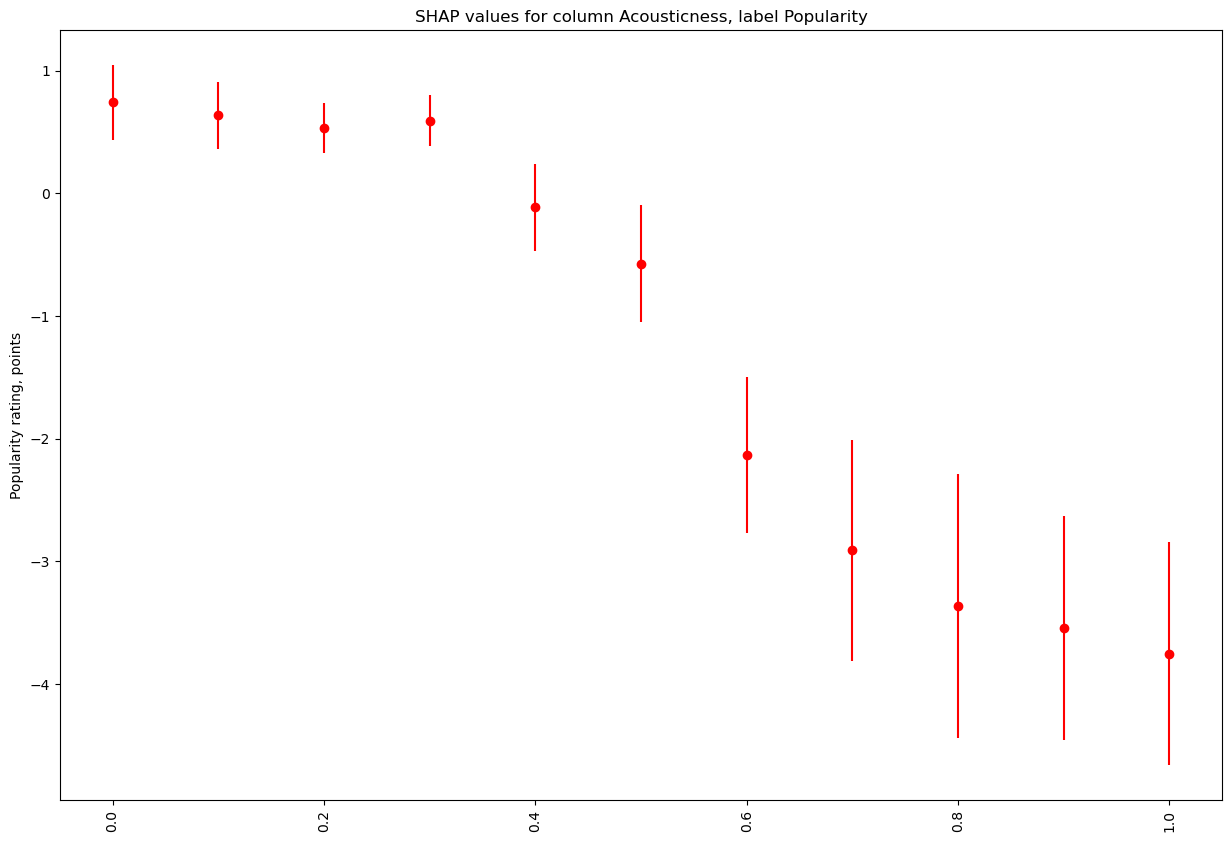

       gain  gain_std  count
col                         
0.0  0.7404    0.3040   1397
0.1  0.6353    0.2739    714
0.3  0.5897    0.2080    284
0.2  0.5314    0.2036    410
0.4 -0.1151    0.3572    176
0.5 -0.5730    0.4774    155
0.6 -2.1328    0.6345    142
0.7 -2.9083    0.9011    175
0.8 -3.3607    1.0747    118
0.9 -3.5434    0.9107     65
1.0 -3.7520    0.9083     11

Instrumentalness



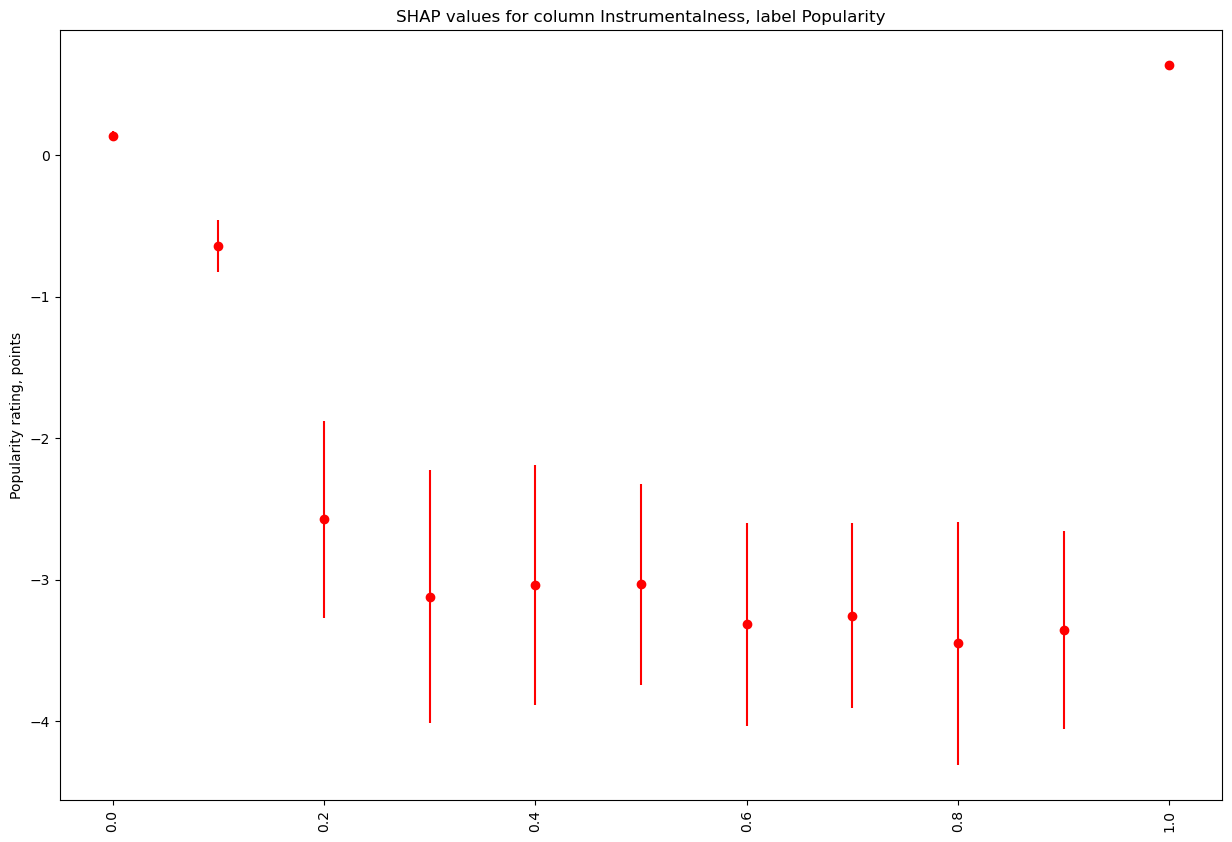

       gain  gain_std  count
col                         
1.0  0.6366       NaN      1
0.0  0.1342    0.0348   3355
0.1 -0.6413    0.1861     99
0.2 -2.5730    0.6959     46
0.5 -3.0328    0.7085     24
0.4 -3.0363    0.8482     17
0.3 -3.1205    0.8944     24
0.7 -3.2554    0.6531     23
0.6 -3.3160    0.7201     20
0.9 -3.3551    0.7029     18
0.8 -3.4496    0.8606     20

Liveness



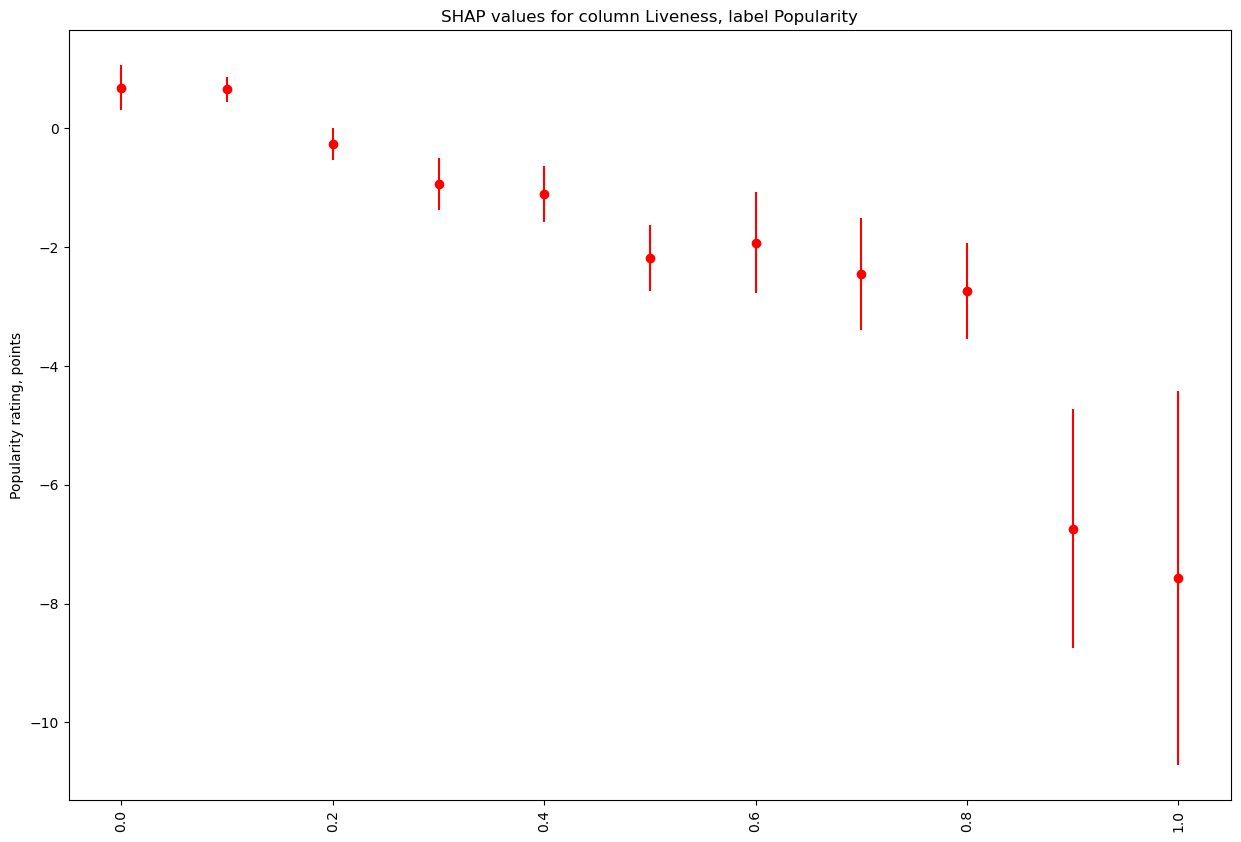

       gain  gain_std  count
col                         
0.0  0.6873    0.3774    149
0.1  0.6601    0.2084   1937
0.2 -0.2651    0.2640    633
0.3 -0.9336    0.4432    486
0.4 -1.1072    0.4744    230
0.6 -1.9260    0.8524     61
0.5 -2.1817    0.5606     66
0.7 -2.4544    0.9466     54
0.8 -2.7397    0.8052     17
0.9 -6.7381    2.0183     11
1.0 -7.5702    3.1514      3

Valence



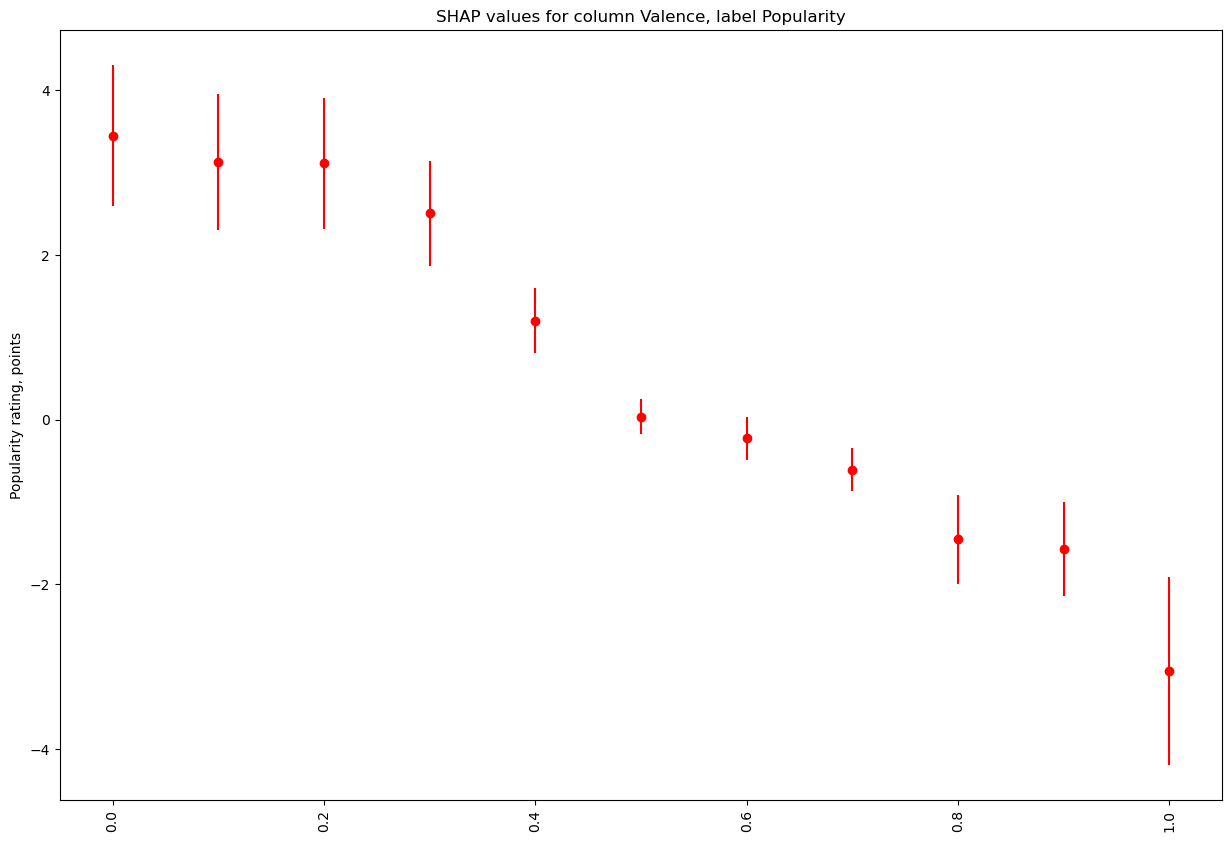

       gain  gain_std  count
col                         
0.0  3.4472    0.8567      9
0.1  3.1314    0.8233    112
0.2  3.1101    0.7963    254
0.3  2.5063    0.6361    332
0.4  1.1993    0.3962    390
0.5  0.0340    0.2106    494
0.6 -0.2294    0.2590    480
0.7 -0.6090    0.2595    480
0.8 -1.4512    0.5409    493
0.9 -1.5676    0.5713    414
1.0 -3.0523    1.1437    189

Tempo



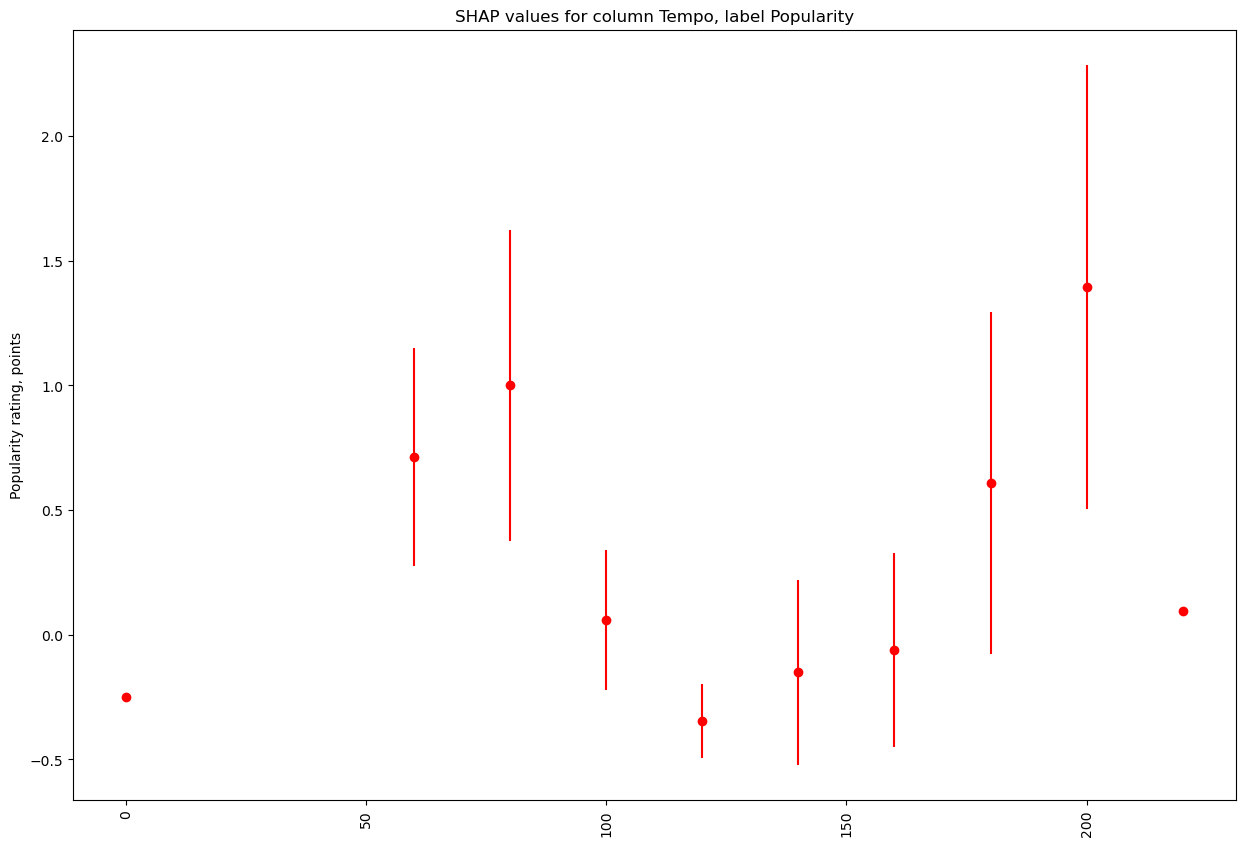

       gain  gain_std  count
col                         
200  1.3957    0.8904     42
80   1.0005    0.6229    364
60   0.7130    0.4384     16
180  0.6089    0.6848    166
220  0.0944       NaN      1
100  0.0582    0.2803    897
160 -0.0606    0.3897    252
140 -0.1500    0.3710    646
0   -0.2516       NaN      1
120 -0.3464    0.1487   1262

Time Signature



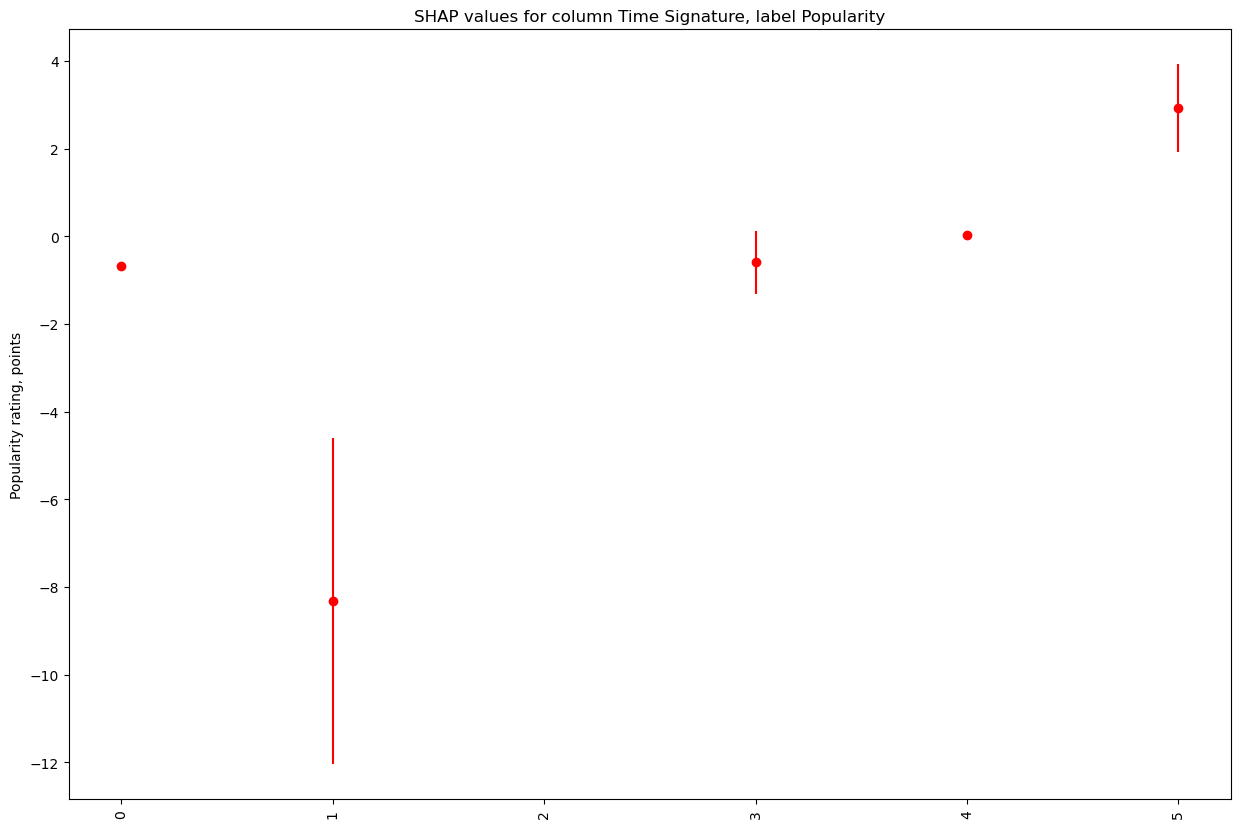

       gain  gain_std  count
col                         
5.0  2.9216    1.0022     27
4.0  0.0261    0.0379   3478
3.0 -0.5944    0.7097    133
0.0 -0.6721       NaN      1
1.0 -8.3257    3.7222      8

duration_minutes



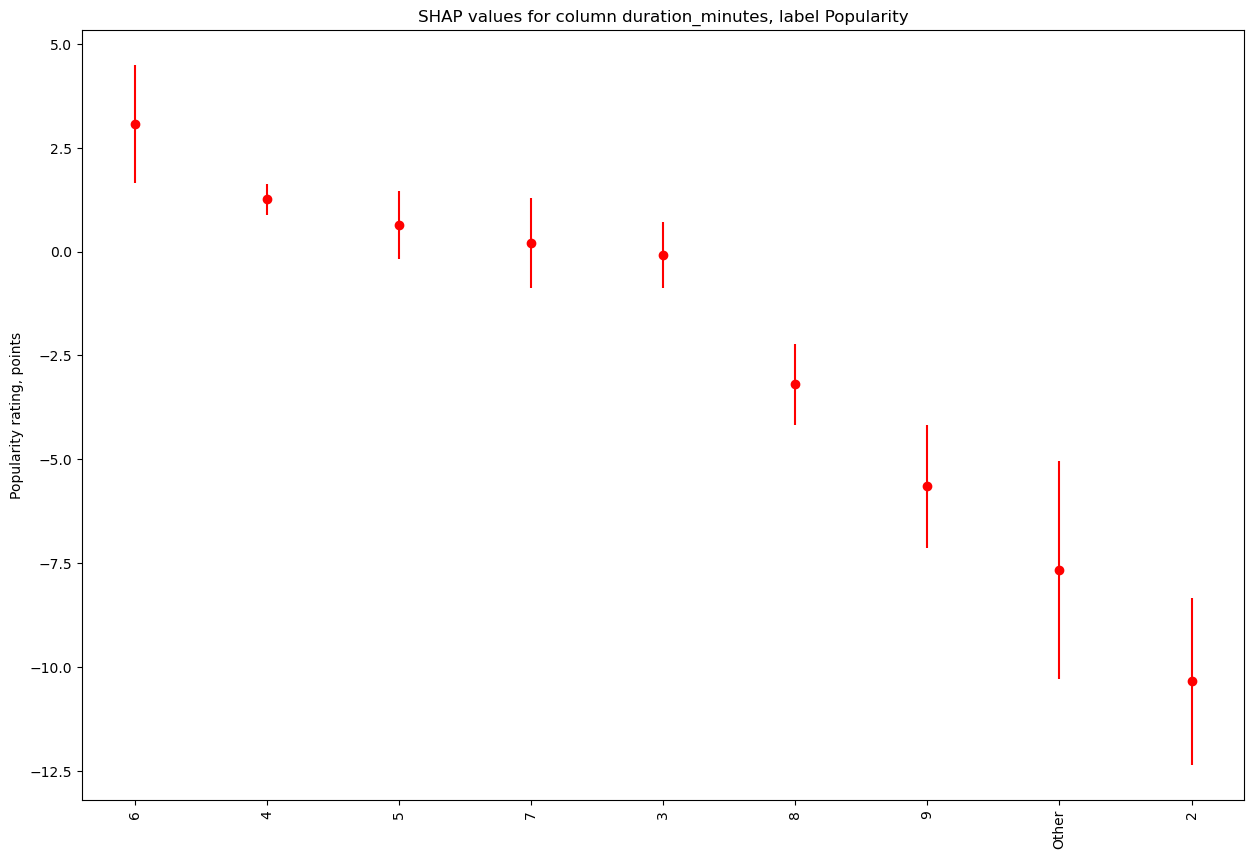

          gain  gain_std  count
col                            
6       3.0671    1.4248     74
4       1.2615    0.3749   1629
5       0.6336    0.8121    399
7       0.1962    1.0834     21
3      -0.0874    0.7935   1331
8      -3.1928    0.9794      6
9      -5.6466    1.4793     10
Other  -7.6656    2.6146      2
2     -10.3471    2.0074    175

release_year



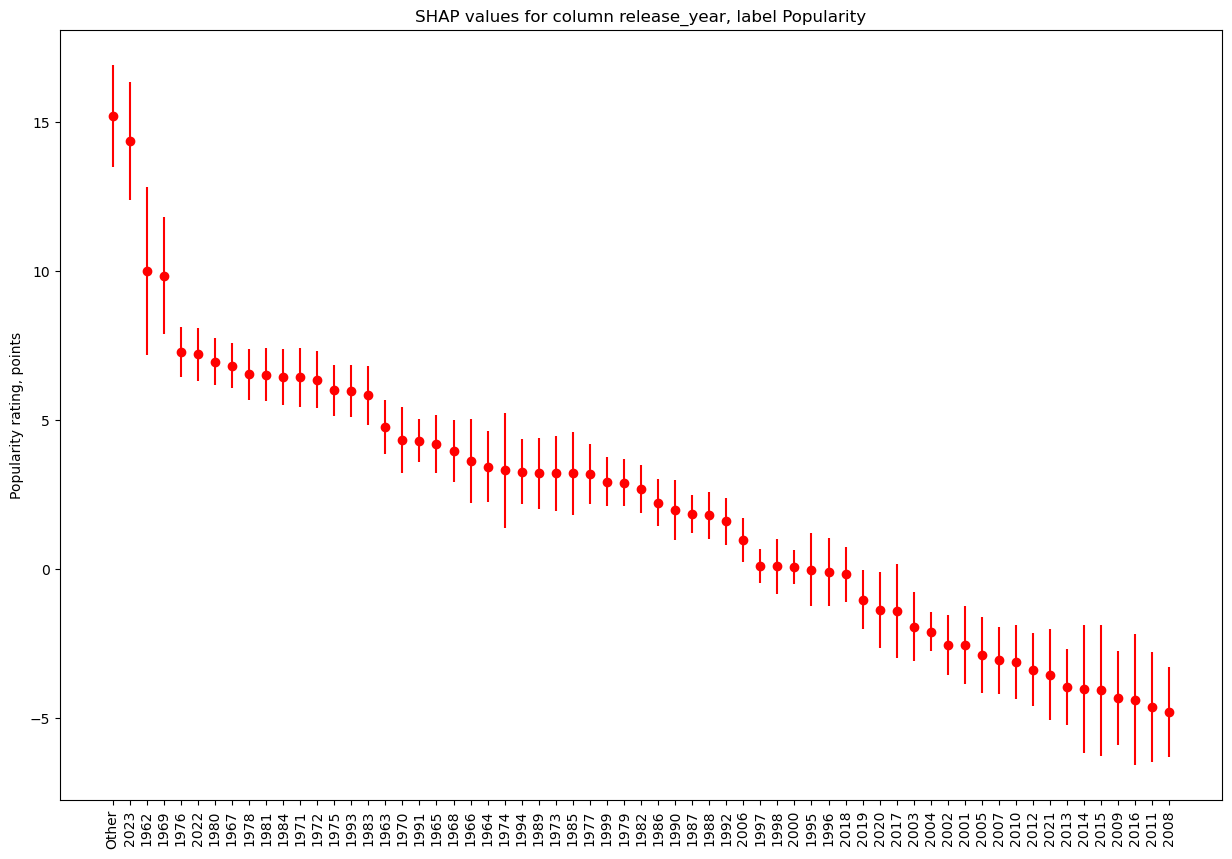

          gain  gain_std  count
col                            
Other  15.2128    1.7126     10
2023   14.3697    1.9679     15
1962   10.0062    2.8302     13
1969    9.8521    1.9700     27
1976    7.2790    0.8426     36
2022    7.2089    0.8837     23
1980    6.9572    0.7895     34
1967    6.8311    0.7472     20
1978    6.5347    0.8561     28
1981    6.5289    0.9010     33
1984    6.4428    0.9472     28
1971    6.4285    0.9904     22
1972    6.3595    0.9504     25
1975    5.9949    0.8519     26
1993    5.9743    0.8750     42
1983    5.8318    0.9926     28
1963    4.7699    0.9132     10
1970    4.3310    1.1151     37
1991    4.3056    0.7167     33
1965    4.1881    0.9648     19
1968    3.9749    1.0418     26
1966    3.6303    1.4000     24
1964    3.4340    1.1978     21
1974    3.3059    1.9403     32
1994    3.2610    1.0899     45
1989    3.2147    1.1885     38
1973    3.2119    1.2564     31
1985    3.2105    1.3933     36
1977    3.1913    1.0150     42
1999    

In [14]:
def show_shap(col, shap_values=shap_values, label=main_label, X_test=X_test):
    df_infl = X_test.copy()
    df_infl['shap_'] = shap_values[:,df_infl.columns.tolist().index(col)]
    gain = round(df_infl.groupby(col).mean()['shap_'],4)
    gain_std = round(df_infl.groupby(col).std()['shap_'],4)
    cnt = df_infl.groupby(col).count()['shap_']
    dd_dict = {'col': list(gain.index), 'gain': list(gain.values), 'gain_std': list(gain_std.values), 'count': cnt}
    df_res = pd.DataFrame.from_dict(dd_dict).sort_values('gain', ascending=False).set_index('col')
    plt.figure(figsize=(15,10))
    plt.errorbar(df_res.index, df_res['gain'], yerr=df_res['gain_std'], fmt="o", color="r")
    plt.title(f'SHAP values for column {col}, label {label}')
    plt.ylabel('Popularity rating, points')
    plt.tick_params(axis="x", rotation=90)
    plt.show();
    print(df_res)
    return

for col in X_test.columns:
    print()
    print(col)
    print()
    show_shap(col, shap_values, label=main_label, X_test=X_test)